<h1 align="center" style="color:Purple;font-size: 3em;" >PREDICT FUTURE SALES</h1>
    
    
<h2 style="color:Purple">INDEX</h2>


* [1. Introduction](#section1)
* [2. Import Libraries](#section2)
* [3. Data Overwiew](#section3)
* [4. Exploratory Data Analysis](#section4)
  * [Basic Analysis](#section4)
  * [Analysis On Date](#section5)
  * [Analysis on Number of Units Sold(item_cnt_day)](#section6)
  * [Analysis On Item Price](#section7)
    * [Q. How does sales over each day looks like?](#section8)
    * [Q. Do price of an item changer over time?](#section8)
  * [Analysis On Shop_id, item_id and item_category_id](#section9)
    * [Q. Do all item ids and shop ids present in train is present in test?](#section9) 
    * [Q. Which shop id, item id and item category id have maximum sales?](#section10)
    * [Q. Are there any items which are more than in one category.ie Do an item belongs to single category or not?](#section11)
    * [Q. What about Monthly Sales?](#section12)
    * [Q. Do all the shops sold items on all months from 2013 Jan to 2015 Oct?](#section13)
* [5. Baseline Model](#section14)
  * [Lag Features](#section15)
  * [Train validation split](#section16)
  * [Models](#section17)
    - [Random Forest Model](#section18)
    - [Xgboost Model](#section19)
    
* [6. Feature Engineering](#section20)
  * [Lag features based on average number of items sold per month](#section21)
  * [Lag features based on average number of items sold per month on each shop](#section22)
  * [Lag features based on average number of each item sold per month](#section23)
  * [Lag features based on Revenue](#section24)
* [7. Final Model](#section25)
* [8. Summary](#section26)
  * [Approach](#section26)
  * [Experiments that didnot improved results](#section26)
  * [Scope of improvement](#section26) 



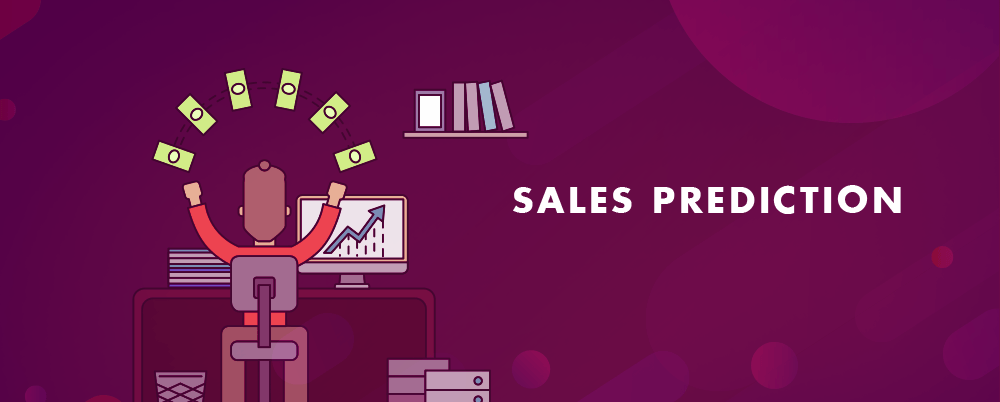

<a class="anchor" id="section1"></a>

<h1 style="color:Purple">1. Introduction</h1> 

<h2 style="color:Purple"> Understanding Business Objective </h2>

<p>
Here we will work with a challenging time-series dataset consisting of daily sales data, provided by one of the largest Russian software firms - 1C Company. We are given sales for 34 months from 2013 Jan to 2015 October.We need to predict no of each of the item that will gets sold in the month of november 2015 for given shop.ie, We will have a shop_id(unique identifier of a shop) and an item_id(unique identifier of an item) and we have to predict the number of units that item will gets sold in the month of november.<br>

***Note: Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.***<p>

<a class="anchor" id="section2"></a>

<h1 style="color:Purple">2. Importing Libraries</h1>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec
from termcolor import colored
import gc,time,os


plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

<a class="anchor" id="section3"></a>
<h1 style="color:Purple">3. Data Overview</h1>


We have mainly 5 files:

```
1. train.csv  -> showing item price and number of items sold on each date. 
2. shop.csv -> Details of shops corresponding to shop id in train.csv.
3. item.csv -> Details of items corresponding to item id in train.csv
4. item_categories.csv -> Details of item category corresponding to category id in item.csv
5. test.csv -> test data for prediction
```

Let us give an glimpse on each of the files

```
train.csv
--------

- date: date in format dd/mm/yy.
- date_block_num: a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1 and so on.
- shop_id: unique identifier of a shop.
- item_id: unique identifier of a product.
- item_price: current price of an item.
- item_cnt_day: number of products sold. We are predicting a monthly amount of this measure.


shop.csv
--------
- shop_name: shop name corresponding to shop id in train.csv
- shop_id

item.csv
--------
- item_name: item name corresponding to item id in train.csv
- item_id
- item_category_id: category id of item


item_category.csv
-----------------
- item_category_name: category name of item cooresponding to item_category_id in item.csv 
- item_category_id

test.csv
----------
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id
- item_id

```

<a class="anchor" id="section4"></a>
<h1 style="color:Purple">4.Exploratory Data Analysis</h1>

<h2 style="color:Purple">Basic Analysis</h2>

In [ ]:
# file paths
DIR_PATH = '/kaggle/input/competitive-data-science-predict-future-sales'
TRAIN_SALES_CSV = '/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv'
SHOPS_CSV = '/kaggle/input/competitive-data-science-predict-future-sales/shops.csv'
ITEMS_CSV= '/kaggle/input/competitive-data-science-predict-future-sales/items.csv'
ITEM_CATEGORY_CSV = '/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv'
TEST_CSV = '/kaggle/input/competitive-data-science-predict-future-sales/test.csv'

In [ ]:

def show_data(df_train,heading='TRAIN DATA'):
    
    """
    function which gives basic data information
    Args:
        df_train: pandas dataframe
        heading: deading to display
    Returns:
        None
    """

    print(colored(heading,'red'))
    print('')
    print('Date shape')
    print(f'shape:{df_train.shape}')
    print('')
    print('--'*50)
    print('')
    print('Sample:')
    print(df_train.head(3).to_markdown())
    print('')
    print('--'*50)
    print('')
    print('Columns and data types:')
    print('')
    print(df_train.info())


In [ ]:
df_train = pd.read_csv(TRAIN_SALES_CSV)
df_shop = pd.read_csv(SHOPS_CSV)
df_item = pd.read_csv(ITEMS_CSV)
df_itemcat = pd.read_csv(ITEM_CATEGORY_CSV)

show_data(df_train,heading='TRAIN DATA')
print('')
print('__'*40)
print('')
show_data(df_shop,heading='SHOP DATA')
print('')
print('__'*40)
print('')
show_data(df_item,heading='ITEM DETAILS DATA')
print('__'*40)
print('')
show_data(df_itemcat,heading='ITEM CATEGORY DATA')

In [ ]:
df_test = pd.read_csv(TEST_CSV)
show_data(df_test,heading='TEST DATA')

<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br>  
As discussed earlier for test data we just have shop id and item id. Train data is spread over 4 files. From above samples we know that there are common ids on multiple files.It will be great to move forward once we merge those train files based on common id. </p>

In [ ]:
### Merging all dataframes together
dff = df_train.merge(df_item,on="item_id")
dff = dff.merge(df_itemcat,on="item_category_id")
dff = dff.merge(df_shop,on="shop_id")
dff = dff.drop(columns=["item_name"])
dff.to_csv('merged_original.csv',index=False)

In [ ]:
#masking a copy
df = dff.copy()
# df.to_csv('merged_original.csv',index=False)
df.head()

In [ ]:
df.describe()

Ok. Now we have our merged data. Let us go through each of the features


<a class="anchor" id="section5"></a>
<h2 style="color:Purple">Analysis On Date</h2>


In [ ]:
df["date"]=  pd.to_datetime(df["date"], format='%d.%m.%Y')
df.sort_values(by="date", ascending=True, inplace=True)
print(f'Minimum data present: {df["date"].min()}')
print(f'Maximum date present: {df["date"].max()}')

In [ ]:
# sorting dataframe based on date
df = df.sort_values(by='date').reset_index(drop=True)
df.head()

<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br> 
- Our 'date' was not in date time format.We have converted it to datetime and sorted our dataframe based on that.</p>

<a class="anchor" id="section6"></a>
<h2 style="color:Purple">Analysis on number of units sold (item_cnt_day)</h2>

item_cnt_day is the number of units of that item sold in that shop on a particular day.

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(df['item_cnt_day'],ax=axes[0])
axes[0].set_title('Boxplot')
sns.distplot(df['item_cnt_day'],ax=axes[1])
axes[1].set_title('Distribution')
plt.suptitle('No of units sold(Item Cnt day)',fontsize="20")
plt.show()

In [ ]:
df['item_cnt_day'].describe()

In [ ]:
print(f'Minimum value {df["item_cnt_day"].min()}')
print(f'Maximum value {df["item_cnt_day"].max()}')

* We have minimum value of -22 which does not make sense.ie, no of items sold cannot be negative number. We will remove those values under 0

In [ ]:
# Let us print percentile values
for i in range(0,101,10):
    print(f'{i}th percentile value for item_cnt_day is {np.percentile(df["item_cnt_day"],i)}')
    
print('--'*50)

for i in range(90,100):
    print(f'{i}th percentile value for item_cnt_day is {np.percentile(df["item_cnt_day"],i)}')
    
print('--'*50)

for i in range(1,10):
    k = 99 + i/10 
    print(f'{k}th percentile value for item_cnt_day is {np.percentile(df["item_cnt_day"],k)}')

In [ ]:
# we will remove some extreme out layers
df[df['item_cnt_day'] > df['item_cnt_day'].quantile(0.95)]

In [ ]:
df[df['item_cnt_day'] < 0]

In [ ]:

print(f'shape of data after before outliers: {df.shape}')
df = df[df['item_cnt_day'] >= 0]
upper_quantile = df['item_cnt_day'].quantile(0.95)
print(f'Removing values greater that upper_quantile {upper_quantile} and less than 0')
df['item_cnt_day'] = np.where(df['item_cnt_day'] > upper_quantile, upper_quantile, df['item_cnt_day'])

print(f'shape of data after removing outliers: {df.shape}')
print(f'Minimum units of product sold a time {df["item_cnt_day"].min()}')
print(f'Maximum units of product sold a time {df["item_cnt_day"].max()}')

<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br> 
    - Most of the items are only sold 1 in quantity.Even 75th percentile value is 1.<br>
       - We have some values less that zeros which ideally should not present. ie, no of units sold cannot be less than or equal to            zero.Also we have some extreme outliers. After some analysis, we decide to remove all those values > 0.95 percentile.<br>
</p>
   

<a class="anchor" id="section7"></a>
<h2 style="color:Purple">Analysis On Item Price</h2>

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(df['item_price'],ax=axes[0])
axes[0].set_title('Boxplot')
sns.distplot(df['item_price'],ax=axes[1])
axes[1].set_title('Distribution')
plt.suptitle('Item Price per unit',fontsize="20")
plt.show()

In [ ]:
df['item_price'].describe()

Here also we have some item whose price is less than 0 which is not acceptable.

In [ ]:
# Let us print percentile values
for i in range(0,101,10):
    print(f'{i}th percentile value for item_price is {np.percentile(df["item_price"],i)}')
    
print('--'*50)

for i in range(90,100):
    print(f'{i}th percentile value for item_price is {np.percentile(df["item_price"],i)}')
    
print('--'*50)

for i in range(1,10):
    k = 99 + i/10 
    print(f'{k}th percentile value for item_price is {np.percentile(df["item_price"],k)}')

In [ ]:
# we have an extreme outlier value in item price. Let us remove it

print(f'shape of data before removing outliers: {df.shape}')
df = df[df['item_price'] >= 0]
upper_quantile = df['item_price'].quantile(0.95)
df['item_price'] = np.where(df['item_price'] > upper_quantile, upper_quantile, df['item_price'])
print(f'shape of data after removing outliers: {df.shape}')

print(f'Minimum price of a single item {df["item_price"].min()}')
print(f'Maximum price ofa single item {df["item_price"].max()}')

<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br>
       - We have some item price less that zeros which ideally should not present.<br>
       - Also we have some extreme outliers. After some analysis, we decide to remove all those values > 0.95 percentile similar to item_cnt_day.<br>
       - After removing outliers, We have some products with price low as 0.07(Might be some chocolate).
Also we have some item which costs about 2683(Might be a chair)
</p>
   


<a class="anchor" id="section10"></a>

<p style="border:4px; border-style: solid double; border-color:red; padding: 2em;">
    <b style="font-size:1.4em;"> Question: </b><br>
    <b style="font-size:1.5em;">Do price of an item develop over time?</b><br>

</p>




Before getting in to let us take a sample of items which are getting sold on each day. Also it is important to note that there might be price change for the same item in different shops.So let us consider price development of sample of items in the same shop.

In [ ]:
df_tmp = df[df['shop_id'] == 31][['date','item_id','item_price']].reset_index(drop=True)
items = df_tmp['item_id'].unique()[0:8]

fig,axes = plt.subplots(1,1,figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i,item in enumerate(items):
    dprice = df_tmp[df_tmp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'],y=dprice['item_price'],ax=axes,color=colors[i],label=item)
    
axes.set_title('Price development of items - shop_id 31',fontsize="28")
axes.legend()
plt.show()


df_tmp = df[df['shop_id'] == 28][['date','item_id','item_price']].reset_index(drop=True)
items = df_tmp['item_id'].unique()[0:8]

fig,axes = plt.subplots(1,1,figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i,item in enumerate(items):
    dprice = df_tmp[df_tmp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'],y=dprice['item_price'],ax=axes,color=colors[i],label=item)
    
axes.set_title('Price development of items - shop_id 28',fontsize="28")
axes.legend()
plt.show()



df_tmp = df[df['shop_id'] == 21][['date','item_id','item_price']].reset_index(drop=True)
items = df_tmp['item_id'].unique()[0:8]

fig,axes = plt.subplots(1,1,figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i,item in enumerate(items):
    dprice = df_tmp[df_tmp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'],y=dprice['item_price'],ax=axes,color=colors[i],label=item)
    
axes.set_title('Price development of items - shop_id 21',fontsize="28")
axes.legend()
plt.show()

<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br>
- We can see that price of the same item is not same over the time(for some items).<br>
- Some items are also not selling on shops after some time.(might have stopped selling those product)<br>
- It increases and decreases over time.<br>
- During feature engineering it may be useful, if we can flag some items whose price remain constant over time<br>
- Here we can see that item price is dependent on time. This is the beauty of time series.<br>
</p>





<a class="anchor" id="section8"></a>

<p style="border:4px; border-style: solid double; border-color:red; padding: 2em;">
    <b style="font-size:1.4em;"> Question: </b><br>
    <b style="font-size:1.5em;">How does sales over each day looks like?</b><br>

</p>


    Let us see how sales distribution looks for a single day. Before that let us create a new feature which is the turn over for an item.We can consider it as total sales for an item from a particular shop on a particular day.
    

In [ ]:
# creating a new feature
df['Sales_per_item'] = df['item_cnt_day'] * df['item_price']

In [ ]:
fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(1, 3)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])
# setting size of xlabel and ylabel
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax02.tick_params(axis='both', labelsize=15)
ax00.set_title('Sales per item', fontsize=20)
ax01.set_title('Item price distribution', fontsize=20)
ax02.set_title('Item count distribution', fontsize=20)
sns.histplot(data = df ,x="Sales_per_item", kde=True, bins=50,ax=ax00, color="violet")
sns.histplot(data = df ,x="item_price", kde=True, ax=ax01, bins=50, color="tomato")
sns.histplot(data = df ,x="item_cnt_day", kde=False, ax=ax02, bins=20, color="cornflowerblue")

fig.subplots_adjust(top=0.8)
fig.suptitle('Sales Feature Distributions per Day', fontsize="28");



<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br>
- We are looking at sales figure on daily basis. It is different from our target distribution <br>
- In most of the days only 1 item is sold. <br>
- We are also getting a clear idea on price range(after removing top 5% items.)
</p>
   



<a class="anchor" id="section9"></a>
<h2 style="color:Purple">Analysis On Shop_id, item_id and item_category_id</h2>



<p style="border:4px; border-style: solid double; border-color:red; padding: 2em;">
    <b style="font-size:1.4em;"> Question: </b><br>
    <b style="font-size:1.2em;">Do all shop id present in test data present in train data and viceversa?</b><br>
    <b style="font-size:1.2em;">Do all item id present in test data present in train data and viceversa?</b><br>
    <b style="font-size:1.2em;">Do all shop id - item id pairs present in test data present in train data and viceversa?</b><br>
    
</p>

 



In [ ]:
train_shop_ids = set(df['shop_id'].unique())
test_shop_ids = set(df_test['shop_id'].unique())

train_item_ids = set(df['item_id'].unique())
test_item_ids = set(df_test['item_id'].unique())

print(f'There are about {len(train_shop_ids)} unique shop ids in train data and {len(test_shop_ids)} shop ids in test data')
print(f'There are about {len(train_item_ids)} unique item ids in train data and {len(test_item_ids)} item ids in test data')
print('--'*50)

df['pair'] = df[['shop_id','item_id']].apply(lambda x: str(x['shop_id'])+'_'+str(x['item_id']),axis=1)
df_test['pair'] = df_test[['shop_id','item_id']].apply(lambda x: str(x['shop_id'])+'_'+str(x['item_id']),axis=1)
train_pair_ids = set(df['pair'].unique())
test_pair_ids = set(df_test['pair'].unique())

print(f'There are {len(train_shop_ids - test_shop_ids)} shop ids present in train data which are not in test data')
print(f'There are {len(train_item_ids - test_item_ids)} item ids present in train data which are not in test data')
print(f'There are {len(train_pair_ids - test_pair_ids)} shop id item id pairs present in train data which are not in test data')

print('--'*50)

print(f'There are {len(test_item_ids - train_item_ids)} item ids present in test data which are not in train data')
print(f'There are {len(test_shop_ids - train_shop_ids)} shop ids present in test data which are not in train data')
print(f'There are {len(test_pair_ids - train_pair_ids)} shop id item id pairs present in test data which are not in train data')







<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.4em;">Observation: </b><br> 
    -  We have about 60 unique shop ids  21807 unique item ids present in train data <br>
    - All shop ids in test data is present in train data<br>
    -  It is important to note that about 363 item ids present in test data is not present in train data. So we have approximatly 363*60(no of unique shop ids)=102796 pairs which are note present in train data. So we can say that our model needs to be robust to capture this unseen patterns.
 </p>


<a class="anchor" id="section10"></a>
<p style="border:4px; border-style: solid double; border-color:red; padding: 2em;">
    <b style="font-size:1.4em;"> Question: </b><br>
    <b style="font-size:1.5em;">Which shop id, item id and item category id have maximum sales?</b><br>

</p>



In [ ]:
print(f'Total number of unique shop ids: {df["shop_id"].nunique()}')
df_tmp = df[["shop_id","Sales_per_item","item_cnt_day"]]
df_tmp= pd.pivot_table(data=df_tmp,index=["shop_id"],aggfunc={"item_cnt_day":np.sum,"Sales_per_item":np.sum}).reset_index()


fig, axes = plt.subplots(2,1,figsize=(20,10))
sns.barplot(x=df_tmp["shop_id"],y=df_tmp["item_cnt_day"],ax=axes[0])
axes[0].set_title("Total number of units sold among various shops")
sns.barplot(x=df_tmp["shop_id"],y=df_tmp["Sales_per_item"],ax=axes[1])
axes[1].set_title('Total turn over in various shops')
plt.suptitle('Shop id', fontsize="28")
plt.show()

In [ ]:
print(f'Total number of unique item ids: {df["item_id"].nunique()}')

df_tmp = df[["item_id","Sales_per_item","item_cnt_day"]]
df_tmp= pd.pivot_table(data=df_tmp,index=["item_id"],aggfunc={"item_cnt_day":np.sum,"Sales_per_item":np.sum}).reset_index()
df_tmp_sales = df_tmp.sort_values(by=['Sales_per_item'],ascending=False).head(50).reset_index(drop=True)
df_tmp_count = df_tmp.sort_values(by=['item_cnt_day'],ascending=False).head(50).reset_index(drop=True)

fig, axes = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=df_tmp_count["item_id"],y=df_tmp_count["item_cnt_day"],ax=axes[0])
axes[0].set_title("Top selling items of no of units sold")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45)
sns.barplot(x=df_tmp_sales["item_id"],y=df_tmp_sales["Sales_per_item"],ax=axes[1])
axes[1].set_title('Top selling items in terms of Turn over')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45)
plt.suptitle('Item id', fontsize="28")
plt.show()
# del df_tmp,df_tmp_count,df_tmp_sales

In [ ]:
print(f'Total number of unique item categorical ids: {df["item_category_id"].nunique()}')

df_tmp = df[["item_category_id","Sales_per_item","item_cnt_day"]]
df_tmp= pd.pivot_table(data=df_tmp,index=["item_category_id"],aggfunc={"item_cnt_day":np.sum,"Sales_per_item":np.sum}).reset_index()
df_tmp_sales = df_tmp.sort_values(by=['Sales_per_item'],ascending=False).head(50).reset_index(drop=True)
df_tmp_count = df_tmp.sort_values(by=['item_cnt_day'],ascending=False).head(50).reset_index(drop=True)

fig, axes = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=df_tmp_count["item_category_id"],y=df_tmp_count["item_cnt_day"],ax=axes[0])
axes[0].set_title("Top selling items of no of units sold")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45)
sns.barplot(x=df_tmp_sales["item_category_id"],y=df_tmp_sales["Sales_per_item"],ax=axes[1])
axes[1].set_title('Top selling items in terms of Turn over')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45)
plt.suptitle('Item Categorical id', fontsize="28")
plt.show()
del df_tmp,df_tmp_count,df_tmp_sales


<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br>
- We have maxium units sold as well as maxiumum sales in shop id 31.<br>
- We have maximum units sold for item 20949. But maximum sales in terms of Turn over is for item number 3732. Its more over like selling of chocolate and television.<br>
- Similarly for item categories, we have maximum number of unit sold for item_category_id 40 while maximum sales in terms of turn over occured to category id 19.<br>
</p>


<a class="anchor" id="section11"></a>
<p style="border:4px; border-style: solid double; border-color:red; padding: 2em;">
    <b style="font-size:1.4em;"> Question: </b><br>
    <b style="font-size:1.5em;">Are there any items which are more than in one category.ie Do an item belongs to single category or not?</b><br>

</p>



In [ ]:
item_categories = df['item_category_id'].unique()
tmp = df[['item_id','item_category_id']].groupby(by="item_id").nunique().reset_index()
tmp.head()

In [ ]:
tmp['item_category_id'].unique()


<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br>
- We can see that there is only 1 category corresponding to a item_id
</p>



<a class="anchor" id="section12"></a>
<p style="border:4px; border-style: solid double; border-color:red; padding: 2em;">
    <b style="font-size:1.4em;"> Question: </b><br>
    <b style="font-size:1.5em;">What about Monthly Sales?</b><br>

</p>



In [ ]:
#creating some new features
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month
df["day_of_month"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.day_of_week

In [ ]:

fig,axes = plt.subplots(2,1,figsize=(25,12))
df_tmp = df[['date_block_num','Month','Sales_per_item']].groupby(by=['date_block_num']).aggregate("sum").reset_index()
sns.lineplot(x=df_tmp['date_block_num'],y=df_tmp['Sales_per_item'],ax=axes[0])
axes[0].set_title('Total turn over (Total Sales)',fontsize="25")
axes[0].set_xlabel('Date',fontsize="20")
axes[0].set_ylabel('Turn over per month',fontsize="20")


df_tmp = df[['date_block_num','Month','item_cnt_day']].groupby(by=['date_block_num']).aggregate("sum").reset_index()
sns.lineplot(x=df_tmp['date_block_num'],y=df_tmp['item_cnt_day'],ax=axes[1])
axes[1].set_title('Total units sold',fontsize="25")
axes[1].set_xlabel('Date',fontsize="20")
axes[1].set_ylabel('Turn over per month',fontsize="20")

plt.tight_layout()
del df_tmp
plt.show()

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(25,8))
df_tmp = df[['Year','Month','Sales_per_item']].pivot_table(index=['Month'],columns=['Year'],aggfunc={"Sales_per_item":np.sum})
axes[0].plot(df_tmp)
axes[0].set_title('Total turn over (Total Sales)')
axes[0].legend(labels=[i[1] for i in df_tmp.columns])

df_tmp = df[['Year','Month','item_cnt_day']].pivot_table(index=['Month'],columns=['Year'],aggfunc={"item_cnt_day":np.sum})
axes[1].plot(df_tmp)
axes[1].set_title('Total no of units sold')
axes[1].legend(labels=[i[1] for i in df_tmp.columns])
plt.suptitle('Monthly Sales - Yearly',fontsize="28")
plt.show()


<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br>
- We can see that number of products sold as well as total turnover over the months follow almost same pattern.<br>
- We have maximum sales in the month of november and december.<br>
- Since we are predicting sales for november 2015 , we expect a raise in no of units sold




<a class="anchor" id="section13"></a>

<p style="border:4px; border-style: solid double; border-color:red; padding: 2em;">
    <b style="font-size:1.4em;"> Question: </b><br>
    <b style="font-size:1.5em;">
Do all the shops sold items on all months from 2013 Jan to 2015 Oct¶</b><br>
<b style="font-size:1.5em;">Do some shops is deactive on mean time and become active again?</b><br>

</p>


In [ ]:
df_tmp = df[['date_block_num','shop_id','item_cnt_day']]
df_tmp.groupby(by='date_block_num').aggregate({'shop_id':'nunique'}).reset_index()

Let us take a sample of shops and plot the number of total items sold on each month. This gives an idea about the status of the shop in that month

In [ ]:
df_tmp = df[['date_block_num','shop_id','item_cnt_day']]
dt = pd.pivot_table(index='date_block_num',data=df_tmp,columns='shop_id',aggfunc="sum").reset_index(drop=True)
dt = dt.item_cnt_day
dt.columns.name = 'Month'
dt


<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Observation: </b><br>
- We have a total of 60 shops.But all of them are note active during all the months<br>
- For example in case of shop id 9 , it is active only in 9th 21th and 33th month. Shop id 0 and shop id 1 is only active in first two months. Shop id 52 is active on all the months.(From above pivot table)<br>
- We can see that some of the shops are not active in certain months and again they become active<br>
- On feature engineering we can create lag average of sales on shops as a feature.
</p>



<a class="anchor" id="section14"></a>

<h1 style="color:Purple">5. Baseline Model</h1>


Let us get in to the modeling part






In [ ]:
def remove_outliers(df):
    #remove outliers from item_cnt_day
    df = df[df['item_cnt_day'] >= 0]
    upper_quantile = df['item_cnt_day'].quantile(0.95)
    df['item_cnt_day'] = np.where(df['item_cnt_day'] > upper_quantile, upper_quantile, df['item_cnt_day'])
    
    df = df[df['item_price'] >= 0]
    upper_quantile = df['item_price'].quantile(0.95)
    df['item_price'] = np.where(df['item_price'] > upper_quantile, upper_quantile, df['item_price'])
    return df

In [ ]:
#load the merged data
df_train = pd.read_csv('merged_original.csv')
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
print(df_train.shape,df_test.shape)

In [ ]:
#removing outliers as per our analysis
df_train = remove_outliers(df_train)
df_train.shape

In [ ]:
#clippping values as per kaggle discussion
df_train['item_cnt_day'] = df_train['item_cnt_day'].clip(0,20)

<h3 style="color:Purple">Creating a base skelton dataframe which is the combination of all shop_id,item_id in all 34 months.</h3>

After processing,

* We have about 60 unique shop id and 21804 unique item id in train data.
* We have about 42 shop id and 5100 unique item id in test data.
* First we will create a dataframe with each all shop id item id combinations in train. We will create it for all 34 months.
It is important to note that all shop ids and item ids wont be present in all the months.

In [ ]:
from itertools import product
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']

for i in range(34):
    
    # for each month, we are appending all month,shop_id,item_id combinations
    sales = df_train[df_train['date_block_num']==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
        
# creating a dataframe from list
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# convert to np.int8 to reduce memory usage
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix = matrix.reset_index(drop=True)
print(f'{time.time() - ts}')

In [ ]:
print(matrix.shape)
matrix.head()

We will also create a test dataframe similar to it with date_block_num = 34.(which is the 35th month we need to predict).Then we will combine it with our train matrix, so it is easy for computation, espetially lag features.

In [ ]:
# df_test = df_test.drop(columns=['ID'])
# assigning month variable
df_test['date_block_num'] = 34

# conacting with train matrix
matrix = pd.concat([matrix,df_test],axis=0).reset_index(drop=True)

matrix.shape

<h3 style="color:Purple">Getting total number of each item sold per month for each shop</h3>

ie,Total number of each item sold per month on each shop [sum aggregation] - item_cnt_month

ie, corresponding to a single date_block_num,shop_id,item_id we can have multiple rows.ie, in month 0, shop_id 0 and item_id 32 we have about 4 entries. We have to aggregate it to get monthly number of units sold for each item in each shop.

In [ ]:
# example
df_train.loc[(df_train['date_block_num'] == 0) &  (df_train['shop_id'] == 0) & (df_train['item_id'] == 32)]

ie, we can have same item sold on same shop on same month on different days. So we will do an sum aggregation on item_cnt day on combination of 'date_block_num','shop_id','item_id'

In [ ]:
tmp = df_train[['date_block_num','shop_id','item_id','item_cnt_day']]
tmp = tmp.groupby(by=['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum'})
tmp.columns = ['item_cnt_month']
tmp = tmp.reset_index(drop=False)
tmp.head()

Now we will merge with our base skelton frame.

In [ ]:
#merging with main frame
matrix = matrix.merge(tmp,on=['date_block_num','shop_id','item_id'],how='left')
matrix = matrix.fillna(0)

#clip values of max items sold per month to 20
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
del tmp

In [ ]:
matrix.head()

In [ ]:
matrix.tail()


<a class="anchor" id="section15"></a>

<h2 style="color:Purple">Lag Features</h2>


<h3 style="color:Purple">Creating some Lag Features for baseline</h3>

In [ ]:
def lag_feature(df, lags, col):
    """
    creates a lag feature. eg: item_cnt_month corresponding to a shop_id item_id combination of previous month, 
    previous second month etc
    """
    
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

**Understanding Lag features**

Let us create lag feature for 12 months. ie, if we take a particular item sold in a shop in 30th month.

eg:
```
month , shop_id, item_id  item_cnt_month
30        0        7        12   

```

Let the follwong data corresponds to same item_id in same shop in 28th month.
```
month , shop_id, item_id  item_cnt_month
28       0        7        18

```

Now lag_2_item_cnt_month will be as follows:

```
month , shop_id, item_id  item_cnt_month  lag_2_item_cnt_month
30       0        7        12              18

```

I think now you have got an idea regarding lags. This is important since we are creating more features based on it in feature engineering part.

Let us create lag features on item_cnt_month from lag 1 to lag 12.

In [ ]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6,7,8,9,10,11,12], 'item_cnt_month')
#fill missing values
matrix = matrix.fillna(0)
time.time() - ts

<a class="anchor" id="section16"></a>

<h2 style="color:Purple">Train Validation Test Split</h2>

We must be cautious while doing a train validation split. We have data from 2013 Jan to 2015 October and we need to predict Sales of month November.ie we have data of 34 months and we need to predict sales of 35th month.

We will split the data as follows:

```
months 11 to month 33 -> train data  (since we are taking 12 months lag)
month 33 -> validation data
month 34 -> test data (provided in competition)
```

In [ ]:
feats = [i for i in matrix.columns if 'lag' in i] + ['shop_id','item_id','date_block_num','item_cnt_month']

data = matrix[feats]

train_df = data.loc[(data['date_block_num'] > 11) & (data['date_block_num'] < 33)]
val_df = data.loc[data['date_block_num'] == 33]
test_df = data.loc[data['date_block_num'] == 34]

X_train = train_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])
y_train = train_df['item_cnt_month']
X_val = val_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])
y_val = val_df['item_cnt_month']
X_test = test_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

In [ ]:
# del matrix
del data
del train_df
del val_df
del test_df

<a class="anchor" id="section17"></a>

<h2 style="color:Purple">Models</h2>


<a class="anchor" id="section18"></a>

<h2 style="color:Purple">Random Forest</h2>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

**Hyperparameter tuning(grid search)**

In [ ]:
# from itertools import product
# # params
# max_depth = [2,5,10]
# n_estimators = [50,100,150,300]
# min_samples_split = [2,4]

# params =  [max_depth,n_estimators,min_samples_split]
# parameters = list(product(*params))
# min_rmse = float('inf')
# best_params = parameters[0]
# for p in parameters:
#     depth = p[0]
#     estimators = p[1]
#     min_sample_split = p[2]
    
#     print(f"Fitting params -> max_depth: {depth},n_estimators: {estimators} , min_samples_split:{min_sample_split}")
#     model = RandomForestRegressor(random_state=42,max_depth=depth,n_estimators=estimators,min_samples_split=min_sample_split)
#     model.fit(X_train,y_train)
#     y_train_pred = model.predict(X_train)
#     y_val_pred = model.predict(X_val)
    
#     train_rmse = mean_squared_error(y_train,y_train_pred,squared=False)
#     val_rmse = mean_squared_error(y_val,y_val_pred,squared=False)
    
#     print(f'Train rmse: {train_rmse}')
#     print(f'Val rmse: {val_rmse}')
    
#     if val_rmse < min_rmse:
#         min_rmse = val_rmse
#         best_params = p
        
#     print('--'*50)

    
# print(f'Found following best parameters: max_depth: {best_params[0]},\
# n_estimators: {best_params[1]} , min_samples_split:{best_params[2]} with validation loss {min_rmse}')

In [ ]:


model = RandomForestRegressor(random_state=42,max_depth=5,n_estimators=50,min_samples_split=4)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

train_rmse = mean_squared_error(y_train,y_train_pred,squared=False)
val_rmse = mean_squared_error(y_val,y_val_pred,squared=False)

print(f'Train rmse: {train_rmse}')
print(f'Val rmse: {val_rmse}')

In [ ]:
# Y_test = model.predict(X_test).clip(0, 20)
# df_test = pd.read_csv('data/test.csv')
# submission = pd.DataFrame({
#     "ID": df_test.index, 
#     "item_cnt_month": Y_test
# })
# submission.to_csv('submission.csv', index=False)

<a class="anchor" id="section19"></a>

<h2 style="color:Purple">Xgboost Model</h2>

**Hyperparamter tuning(Random search)**

In [ ]:


# import xgboost as xgb
# from itertools import product
# import random

# #params
# booster = 'gbtree'
# silent = 0

# eta = [0.01,0.1,0.2,0.3]  #learning rate in gbm
# min_child_weight = [1,2,0.5]  #minimum sum of weights of all observations required in a child
# max_depth = [3,6,8]  #maximum depth of the tree
# gamma = [0,1]  #a split will occur only when reduction in loss function > gamma 
# subsample = [0.5,0.7,1] #fraction of rows to be sampled to make a decision tree
# colsample_bytree = [0.5,0.7,1] #fraction of columns to be sampled to make a decision tree
# # lambda_ = [0.4,0.8,1] #L2 regularization weights
# alpha = [0,1]  #L1 reg weights



# params =  [eta,min_child_weight,max_depth,gamma,subsample,colsample_bytree,alpha]
# parameters = list(product(*params))
# parameters = random.sample(parameters,100)
# len(parameters)


# min_rmse = float('inf')
# best_params = parameters[0]
# for p in parameters:
#     eta = p[0]
#     min_child_weight = p[1]
#     max_depth = p[2]
#     gamma = p[3]
#     subsample = p[4]
#     colsample_bytree = p[5]
#     alpha = p[6]

#     print('Random Search On Hyperparamters Xgboost')
#     print(f"Fitting params -> eta: {eta},\
# min_child_weight: {min_child_weight} , max_depth:{max_depth}, gamma: {gamma}, subsample : {subsample}, \
# col_sample_bytree: {colsample_bytree:},alpha: {alpha}")
#     model = xgb.XGBRegressor(random_state=42,booster = 'gbtree',verbosity=0,
#                              eta=eta,min_child_weight=min_child_weight,max_depth=max_depth,gamma=gamma,
#                              subsample=subsample,colsample_bytree=colsample_bytree,alpha=alpha)
    
#     model.fit(X_train,y_train)
#     y_train_pred = model.predict(X_train)
#     y_val_pred = model.predict(X_val)
    
#     train_rmse = mean_squared_error(y_train,y_train_pred,squared=False)
#     val_rmse = mean_squared_error(y_val,y_val_pred,squared=False)
    
#     print(f'Train rmse: {train_rmse}')
#     print(f'Val rmse: {val_rmse}')
    
#     if val_rmse < min_rmse:
#         min_rmse = val_rmse
#         best_params = p
        
#     print('--'*50)

    
# print(f'Found following best parameters: eta: {best_params[0]},\
# min_child_weight: {best_params[1]} , max_depth:{best_params[2]}, gamma: {best_params[3]}, subsample : {best_params[4]}, \
# col_sample_bytree: {best_params[5]},alpha: {best_params[6]} with validation loss {min_rmse}')

In [ ]:
import xgboost as xgb
ts = time.time()

model = xgb.XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

In [ ]:
# Y_test = model.predict(X_test).clip(0, 20)
# df_test = pd.read_csv('data/test.csv')
# submission = pd.DataFrame({
#     "ID": df_test.index, 
#     "item_cnt_month": Y_test
# })
# submission.to_csv('submission.csv', index=False)

<a class="anchor" id="section20"></a>

<h1 style="color:Purple">6. Feature Engineering</h1>




Let us try to do some feature engineeing and try to imporove our result.


(Note: Iam only discussion approaches which improved the results. There are approaches which failed which we will discuss later)



<a class="anchor" id="section21"></a>

<h2 style="color:Purple">Lag features based on average number of items sold per month.</h2>

**ie,mean aggregation of item_cnt_month based on date_block_num**


Let us take the average number of items sold per month and create some lag features based on that.

In [ ]:
group = matrix.groupby(by=['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns = ['item_cnt_month_mean_date']
group = group.reset_index()

# merging with skelton
matrix = matrix.merge(group,on=['date_block_num'],how="left")

#adjusting datatype
matrix['item_cnt_month_mean_date'] = matrix['item_cnt_month_mean_date'].astype(np.float16)

In [ ]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'item_cnt_month_mean_date')
#fill missing values
matrix = matrix.fillna(0)
# drop the unneeded feature
matrix = matrix.drop(columns=['item_cnt_month_mean_date'])
time.time() - ts


<a class="anchor" id="section22"></a>

<h2 style="color:Purple">Lag features based on average number of items sold per month on each shop</h2>



**ie,mean aggregation of item_cnt_month based on [date_block_num,shop_id]**


Let us take the average number of items sold per month on each shop and create some lag features based on that.

In [ ]:
group = matrix.groupby(by=['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
group.columns = ['item_cnt_month_mean_date_shopid']
group = group.reset_index()

# merging with skelton
matrix = matrix.merge(group,on=['date_block_num','shop_id'],how="left")

#adjusting datatype
matrix['item_cnt_month_mean_date_shopid'] = matrix['item_cnt_month_mean_date_shopid'].astype(np.float16)

# LAG FEATURES

ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'item_cnt_month_mean_date_shopid')
#fill missing values
matrix = matrix.fillna(0)
# drop the unneeded feature
matrix.drop(columns=['item_cnt_month_mean_date_shopid'],inplace=True)
time.time() - ts



<a class="anchor" id="section23"></a>

<h2 style="color:Purple">Lag features based on average number of each item sold per month</h2>

**ie,mean aggregation of item_cnt_month based on [date_block_num,item_id]**


Let us take the average number of each item sold per month and create some lag features based on that.

In [ ]:
group = matrix.groupby(by=['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group.columns = ['item_cnt_month_mean_date_itemid']
group = group.reset_index()

# merging with skelton
matrix = matrix.merge(group,on=['date_block_num','item_id'],how="left")

#adjusting datatype
matrix['item_cnt_month_mean_date_itemid'] = matrix['item_cnt_month_mean_date_itemid'].astype(np.float16)

# LAG FEATURES

ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'item_cnt_month_mean_date_itemid')
#fill missing values
matrix = matrix.fillna(0)
# drop the unneeded feature
matrix.drop(columns=['item_cnt_month_mean_date_itemid'],inplace=True)
time.time() - ts

<a class="anchor" id="section24"></a>

<h2 style="color:Purple">Lag features based on Revenue (ie sales on item = item_cnt_month*item_price) generated form each item of each month</h2>

**It is basically mean aggregation of revenue based on [date_block_num,item_id]**

In [ ]:
# mean item price per item
df_train['revenue'] = df_train['item_cnt_day']*df_train['item_price']
item_id_price = df_train[['item_id','revenue','date_block_num']].groupby(by=['date_block_num','item_id']).agg({'revenue':['mean']})
item_id_price.columns = ['mean_revenue']
item_id_price = item_id_price.reset_index()
matrix = matrix.merge(item_id_price,on=['date_block_num','item_id'],how="left")
matrix['mean_revenue'] = matrix['mean_revenue'].astype(np.float16)


#lag features
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'mean_revenue')

for i in lags:
    matrix['mean_revenue_lag_'+str(i)] = matrix['mean_revenue_lag_'+str(i)].fillna(0)

<a class="anchor" id="section25"></a>

<h1 style="color:Purple">7. Final Model</h1>

Our final model is based on xgboost


In [ ]:
feats = [i for i in matrix.columns if 'lag' in i] + ['shop_id','item_id','date_block_num','item_cnt_month']

data = matrix[feats]
train_df = data.loc[(data['date_block_num'] > 11) & (data['date_block_num'] < 33)]
val_df = data.loc[data['date_block_num'] == 33]
test_df = data.loc[data['date_block_num'] == 34]

X_train = train_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])
y_train = train_df['item_cnt_month']
X_val = val_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])
y_val = val_df['item_cnt_month']
X_test = test_df.drop(columns=['shop_id','item_id','date_block_num','item_cnt_month'])

print(X_train.shape,X_val.shape,X_test.shape)

In [ ]:
# del matrix
del data
del train_df
del val_df
del test_df

In [ ]:
import xgboost as xgb
ts = time.time()

model = xgb.XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

In [ ]:
Y_test = model.predict(X_test).clip(0, 20)
df_test = pd.read_csv(TEST_CSV)
submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

#1.0009


<p style="border:4px; border-style: solid double; border-color:green; padding: 2em;">
    <b style="font-size:1.3em;">Results: </b><br>
    Our final model gave  validation rmse of 0.7693 and Public LB rmse of 1.00092
    </p>

<a class="anchor" id="section26"></a>

<h1 style="color:Purple">8. Summary</h1>




<a class="anchor" id="section26"></a>

<h2 style="color:Purple">Approach</h2>

* Our idea was to create a skelton frame with all date_block_num,shop_id,item_id combinations for train data combine it with similar test data and merge the features created with skelton dataframe.
* Our entire feature engineering was based on lag features.
* Lag features from 1 to 12 on item_cnt_month became our base line model.
* We used data from month 11 to 32 for training(since we are creating lag features up to month 12).month 33 for validation.
* We tried random forest and xgboost as baseline models and xgboost was performing better.
* Baseline xgboost performed 0.77919 on validation data and 1.02153 on Public LB.
* Our entire feature engineering was to improve the results on xgboost model.
* We created lag features of item_cnt_month based on aggregations with item_id,shop_id and date_block_num.
* Also lag features based on revenue(item_price*item_cnt_month) was useful to slightly improve the score.
* Out final xgboost model gave validation rmse of 0.77992 and public LB of 1.00092 (Roughly around top 40%)



<a class="anchor" id="section26"></a>

<h2 style="color:Purple">Experiments which didnot improved results</h2>

* Tried 6 months lag on item_cnt_month instead of 12. But score was less comared to 12 months lag.
* Created some lag features based on item_category_id(with shop_id,item_id,date_block_num) But did not helped the results.
* Used lag features of item_price along with revenue.But didn't helped.
* Found the avg item_price(per month and item id) and find the difference of it with avg item_price per month and generated lag features based on it.But approach didn't made an improvement in score.



<a class="anchor" id="section26"></a>

<h2 style="color:Purple">Scope of Improvements</h2>

* Hyperparameter tuning on final model
* Feature selection techniques will be highly useful since we have lot of features and most of them adding only slight improvements ove the score.
